# Not successful for too noisy image(extra lines) :'(

In [1]:
import difflib
import importlib
import math
import random
import string

import cv2
import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

# importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

# importlib.reload(ocr.utils.beam_search)
# from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [2]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
random.seed(1)

In [5]:
form_size = (1120, 800)

## Load test image

test_image:  (1084, 813)
test_HTR_downsampled:  (1120, 800)


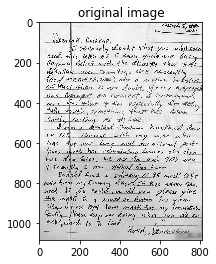

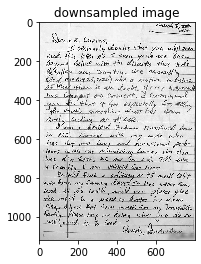

In [6]:
import cv2
from PIL import Image
import IPython.display
from IPython.display import Image
import numpy as np
image = cv2.imread("test_HTR.jpeg")
# original image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("test_image: ", image.shape)
plt.imshow(image, cmap="gray")
plt.title("original image")

# downsampled image
image_resize = cv2.resize(image, dsize=(form_size[1], form_size[0]) ,interpolation=cv2.INTER_CUBIC)
print("test_HTR_downsampled: ", image_resize.shape)
plt.figure()
plt.imshow(image_resize, cmap="gray")
plt.title("downsampled image")

# save downsampled test_image and review
plt.imsave("HTR_downsampled.jpeg", image_resize, cmap="gray")

### Paragraph segmentation

Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [7]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [8]:
paragraph_segmentation_net.hybridize()

(1, 1, 372, 266)


(-0.5, 812.5, 1083.5, -0.5)

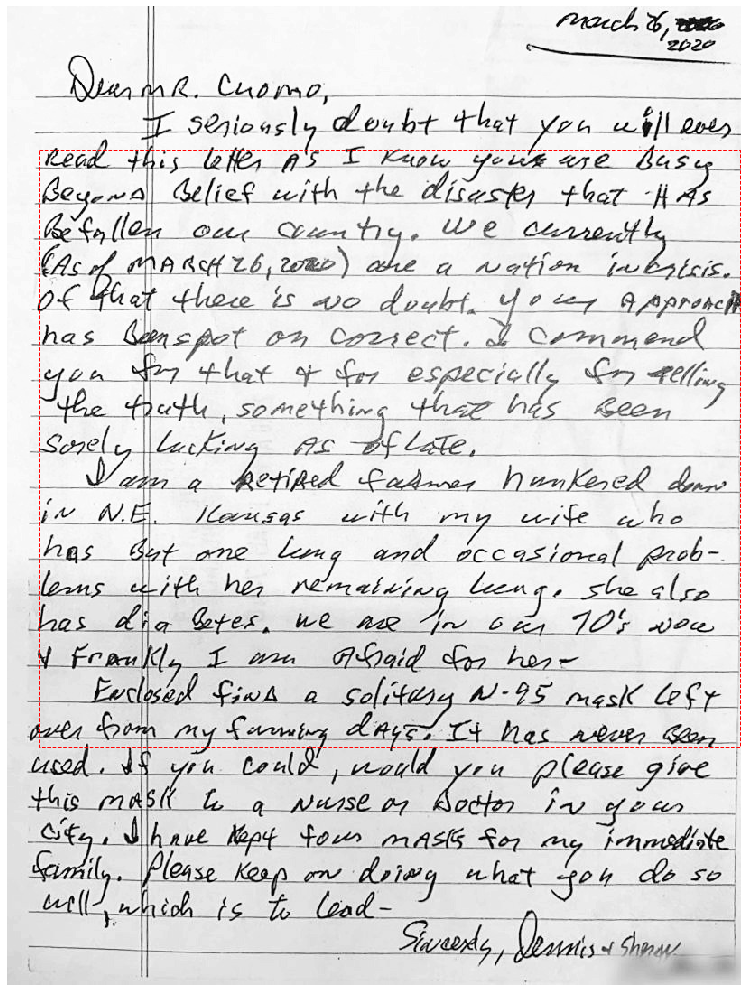

In [9]:
predicted_bbs = []

fig, ax = plt.subplots(1, figsize=(15, 18))

# s_y, s_x = int(i/2), int(i%2)
resized_image = paragraph_segmentation_transform(image, form_size)
print(resized_image.shape)
bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
bb_predicted = bb_predicted[0].asnumpy()
# all train set was in the middle
bb_predicted = expand_bounding_box(bb_predicted, 
                                        expand_bb_scale_x=0.03, expand_bb_scale_y=0.03)
predicted_bbs.append(bb_predicted)

ax.imshow(image, cmap='Greys_r')

(x, y, w, h) = bb_predicted
image_h, image_w = image.shape[-2:]
(x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
ax.add_patch(rect)
ax.axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



(-0.5, 699.5, 699.5, -0.5)

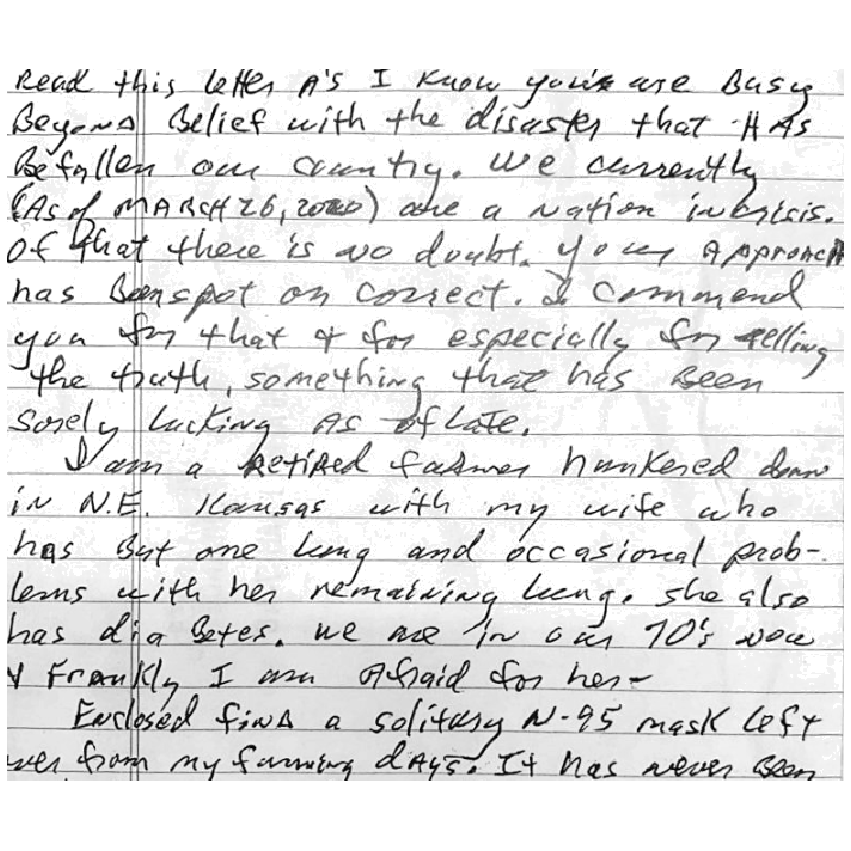

In [10]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(1, figsize=(15, 18))

paragraph_segmented_images = []

bb = bb_predicted
# cv2.imwrite("test.jpg", image)
image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
cv2.imwrite("test.jpg", image)
paragraph_segmented_images.append(image)

# from IPython.display import Image
# Image(image)

plt.imshow(image, cmap='Greys_r')
plt.draw()
plt.axis('off')

## Line/word segmentation

Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [11]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

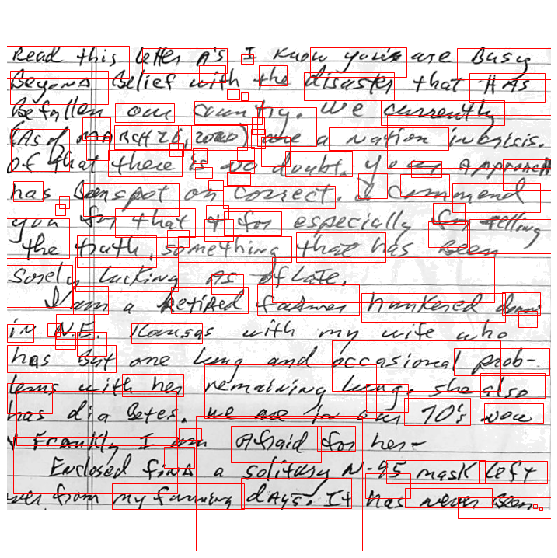

<Figure size 432x288 with 0 Axes>

In [12]:
min_c = 0.1
overlap_thres = 0.15
topk = 600

fig, ax = plt.subplots(1, figsize=(15, 10))
predicted_words_bbs_array = []
paragraph_segmented_image = paragraph_segmented_images[0]

predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

predicted_words_bbs_array.append(predicted_bb)

ax.imshow(paragraph_segmented_image, cmap='Greys_r')
for j in range(predicted_bb.shape[0]):     
    (x, y, w, h) = predicted_bb[j]
    image_h, image_w = paragraph_segmented_image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    ax.add_patch(rect)
    ax.axis('off')

plt.show()
plt.draw()
fig.savefig("test_word_segmentation.jpg")

### Word to line image processing
Algorithm to sort then group all words within a line together.

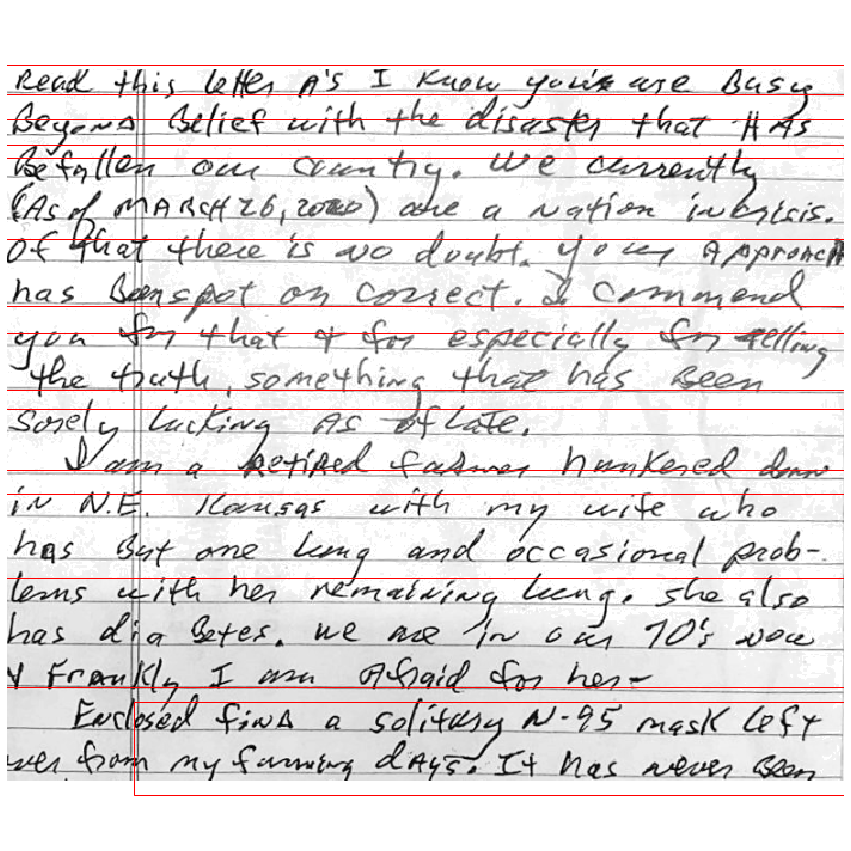

<Figure size 432x288 with 0 Axes>

In [13]:
line_images_array = []
fig, ax = plt.subplots(figsize=(15, 18))

ax.imshow(paragraph_segmented_image, cmap='Greys_r')
ax.axis('off')

predicted_bbs = predicted_words_bbs_array[0]
line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
line_images = crop_line_images(paragraph_segmented_image, line_bbs)
line_images_array.append(line_images)

for line_bb in line_bbs:
    (x, y, w, h) = line_bb
    image_h, image_w = paragraph_segmented_image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    ax.add_patch(rect)


plt.show()
plt.draw()
fig.savefig("Word _to_line.jpg")

## Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [16]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [17]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [18]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [19]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [20]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [21]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [22]:
ctx_nlp = mx.cpu(0)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

We use beam search to sample the output of the denoiser

In [23]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [24]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [25]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [26]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))

This sentnce has an eror
Choice
T h i s   s e n t e n c e 


## Qualitative Result

- [AM] Arg Max CTC Decoding
- [BS] Beam Search CTC Decoding
- [D ] Adding Text Denoiser

[AM] gead tis. YM41 D.3. E KeYy YetizEE Busy
[D ] g o o d   t h i s .   1 4 1   D .   3 .
[AM] Regarioff bilieiiiith the disaster that "ts
[D ] b e f o r e   o f f   b e l i e v e d   w i t
[AM] Baitghefiagopiaaieae" ati " Bafietidiflas
[D ] B a i t   t h e   f i a g o p i a c i e n e
[AM] has aiapia iliiei a fingiereee"
[D ] h a s   r a p i d   m i l i t i e
[AM] yiea ffcgitlisieigiaggiai ling
[D ] g r e a t   e f f i g i b l i s
[AM] sinehiainigigeria igiiniagkeenze
[D ] s i n c e   h i s   i n d i g n i
[AM] Tnngigiagigingigiaaaaiagiaaif
[D ] T r a n g i n g   i m a g i n i
[AM] Rieglaiaenghegigi ei zEre
[D ] R e g l a i n i n g   b e i
[AM] #hf aauig Eihn a ha "aa Ba
[D ] h a l f   c o m i n g   w i


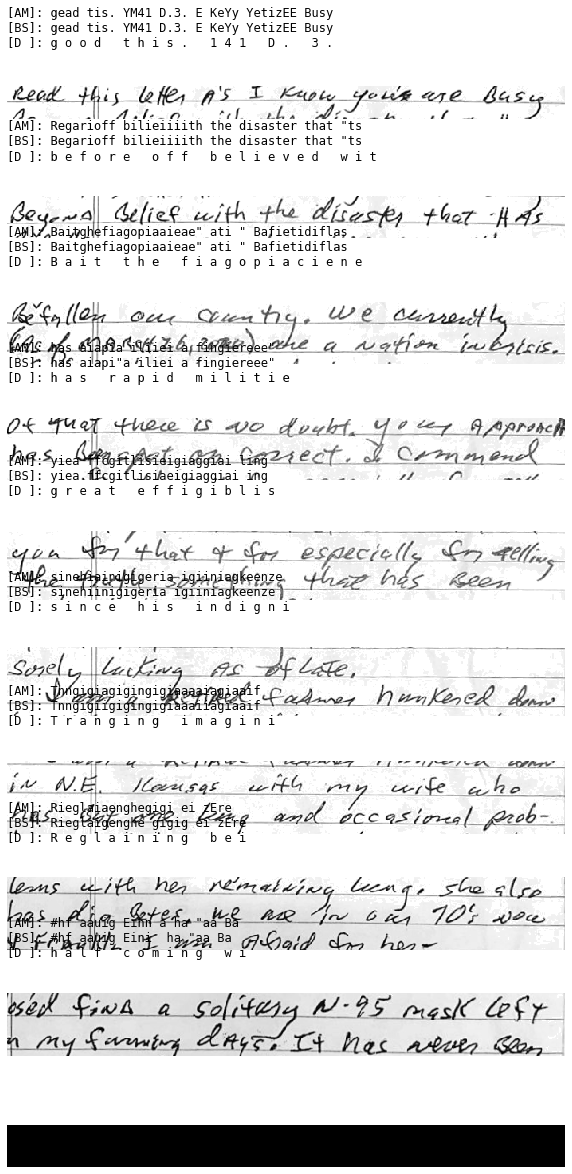

In [27]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [70]:
# only unix-like and linux
# 
# git clone https://github.com/usnistgov/SCTK
# cd SCTK
# export CXXFLAGS="-std=c++11" && make config
# make all
# make check
# make install
# make doc
# cd -
sclite = ScliteHelper('../SCTK/bin')

def get_qualitative_results_lines(denoise_func):
    sclite.clear()
    test_ds_line = IAMDataset("line", train=False)
    for i in tqdm(range(1, len(test_ds_line))):
        image, text = test_ds_line[i]
        line_image = exposure.adjust_gamma(image, 1)
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        decoded_text = denoise_func(character_probabilities)
        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        sclite.add_text([decoded_text], [actual_text])
    
    cer, er = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

AssertionError: ../SCTK/bin does not exist

In [71]:
def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(1, len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = exposure.adjust_gamma(line_image, 1)
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    cer, _ = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

CER with pre-segmented lines

In [72]:
get_qualitative_results_lines(get_arg_max)

NameError: name 'get_qualitative_results_lines' is not defined

In [73]:
get_qualitative_results_lines(get_denoised)

NameError: name 'get_qualitative_results_lines' is not defined

CER full pipeline

In [74]:
get_qualitative_results(get_arg_max)

NameError: name 'sclite' is not defined

In [75]:
get_qualitative_results(get_beam_search)

NameError: name 'sclite' is not defined

In [76]:
cer_denoiser = get_qualitative_results(get_denoised)
cer_denoiser

NameError: name 'sclite' is not defined

In [ ]:
#### ideas:
    - weighted levenshtein
    - re-trained the language model on GBW [~ didn't work too well]
    - only penalize non-existing words
    - Add single word training for denoiser
    - having 2 best edit distance rather than single one
    - split sentences based on punctuation
    - use CTC loss for ranking
    - meta model to learn to weight the scores from each thing